In [2]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

In [3]:
#Standard modules
import os
import time
from datetime import datetime
import random

# Data processing
import numpy as np
import scipy
from sklearn.datasets import make_moons, make_circles

# AI
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F

# Visualization
import matplotlib
import matplotlib.pyplot as plt

#Custom modules
import helpers as hlp
import models as mdl
import run

### Reproductability

In [9]:
SEED = 12345
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Parameters

In [21]:
# Dataset
N_SAMPLES = 400
NOISE = 0.1
FACTOR = 0.7 # Only for make_circles dataset
N_FEATURES = 2
N_CLASS = 2

# Topology
N_CLIENTS = 3
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = 0.7 #'uniform', 'disjoint' or postive.
TOPOLOGY = [[0,1],[1,0]]

# Model
HIDDEN_LAYERS = [64, 16]

# Loss
CRITERION_TR = nn.CrossEntropyLoss()
LAMBDA = 1
TAU = None
CRITERION = hlp.KDLoss("cross-entropy", "KL", coeff=LAMBDA,  tau=TAU)
RANDOM_SAMPLES = 10

# Training
LR = 1e-2
BATCH_SIZE = 16
ROUNDS = 100
START_KD = 0 # Start KD after START_KD * ROUNDS rounds
EPOCHS_PER_ROUND = 1

# Domain limits
MIN, MAX = -2.5, 2.5


# Visualization
AX_SZ = 3
LW = 0.5
S = 10
EC = "black"
MARKER = "o"
MARKER_AREA = "s"
ALPHA_AREA = 0.6
COLORS = ["coral", "lightskyblue"]
H = (MAX-MIN)/25

### Data loading and splitting

Text(0, 0.5, 'Validation data')

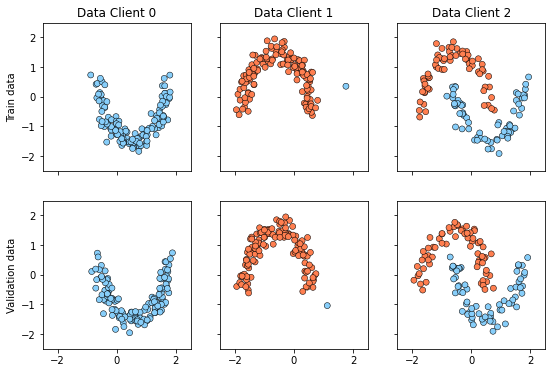

In [22]:
# Loading dummy dataset
train_input, train_target = map(torch.from_numpy, make_moons(n_samples=N_SAMPLES, noise=NOISE))
train_input = train_input.float()
train_input = train_input.sub_(train_input.mean(axis=0, keepdim=True)).div_(train_input.std(axis=0, keepdim=True))
                                                                           
val_input, val_target = map(torch.from_numpy, make_moons(n_samples = N_SAMPLES, noise=NOISE))
val_input = val_input.float()
val_input = val_input.sub_(val_input.mean(axis=0, keepdim=True)).div_(val_input.std(axis=0, keepdim=True))


# Create custom dataset
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

# Split dataset
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, alpha=ALPHA, sizes=SIZES)

# Create dataloaders
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list)
val_dl_global = hlp.ds_to_dl(val_ds)

# Visualization
fig, axs = plt.subplots(2, N_CLIENTS, figsize=(AX_SZ * N_CLIENTS, 2*AX_SZ), sharex=True, sharey=True)
for i in range(N_CLIENTS):
    axs[0,i].scatter(train_ds_list[i].features[:,0], 
                   train_ds_list[i].features[:,1], 
                   c=[COLORS[j] for j in train_ds_list[i].targets], marker=MARKER, edgecolor=EC, lw=LW)


    axs[1,i].scatter(val_ds_list[i].features[:,0], 
               val_ds_list[i].features[:,1], 
               c=[COLORS[j] for j in val_ds_list[i].targets], marker=MARKER, edgecolor=EC, lw=LW)


for i in range(N_CLIENTS):
    axs[0,i].set_title("Data Client {}".format(i))
    axs[0,i].set_xlim(MIN, MAX)
    axs[0,i].set_ylim(MIN, MAX)
    #axs[i].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

axs[0,0].set_ylabel("Train data")
axs[1,0].set_ylabel("Validation data")

### Training (independant)

Epoch 100/100 done.  
Client 0 done.
Epoch 100/100 done.  
Client 1 done.
Epoch 100/100 done.  
Client 2 done.


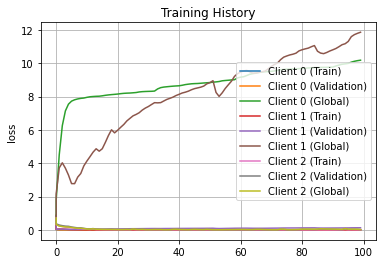

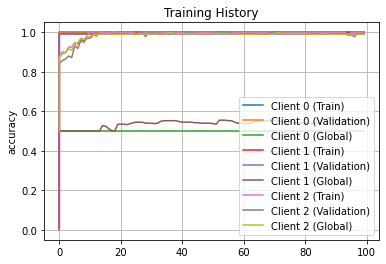

In [23]:
# Model initialization
client_models = [mdl.FC_Net(N_FEATURES, HIDDEN_LAYERS, N_CLASS) for i in range(N_CLIENTS)]

# Performance tracker
pt_list = [hlp.PerfTracker(client_models[i], 
                           {"Train": train_dl_list[i], 
                            "Validation": val_dl_list[i], 
                            "Global": val_dl_global},
                            CRITERION_TR, N_CLASS, None, ID="Client {}".format(i)) 
           for i in range(N_CLIENTS)]

# Optimizer
optimizers = [torch.optim.Adam(model.parameters(), lr=LR) for model in client_models]

for i, model in enumerate(client_models):
    # Initialization
    optimizer = optimizers[i]
    model.train()

    #Teacher learning
    for e in range(ROUNDS * EPOCHS_PER_ROUND):
        for features, target in train_dl_list[i]:
            optimizer.zero_grad()
            output = model(features)
            loss = CRITERION_TR(output, target)
            loss.backward()
            optimizer.step()

        #Tracking performance
        pt_list[i].new_eval(index=e)
        print("\rEpoch {}/{} done.".format(e+1, ROUNDS * EPOCHS_PER_ROUND), end="  ")
    print("\nClient {} done.".format(i))
    
# Visualization of training history
hlp.plot_global_training_history(pt_list,metric="loss")
hlp.plot_global_training_history(pt_list,metric="accuracy")

### Training (random KD loss)

Round 100/100 done.  

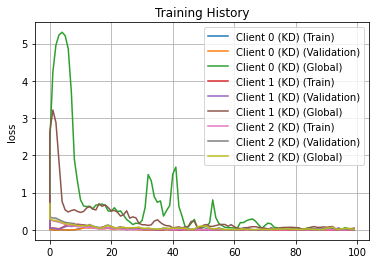

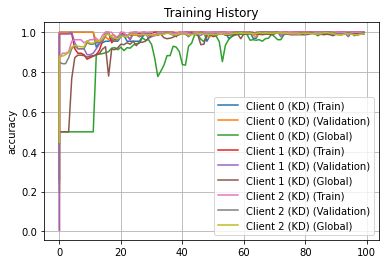

In [24]:
# Model initialization
client_models_KD = [mdl.FC_Net(N_FEATURES, HIDDEN_LAYERS, N_CLASS) for i in range(N_CLIENTS)]

# Performance tracker
pt_list_KD = [hlp.PerfTracker(client_models_KD[i], 
                           {"Train": train_dl_list[i], 
                            "Validation": val_dl_list[i], 
                            "Global": val_dl_global},
                            CRITERION_TR, N_CLASS, None, ID="Client {} (KD)".format(i)) 
           for i in range(N_CLIENTS)]

# Optimizer
optimizers_KD = [torch.optim.Adam(model.parameters(), lr=LR) for model in client_models_KD]

for r in range(ROUNDS):
    # Initialize KD data list
    KD_data_others = [None for _ in range(N_CLIENTS)]
    
    for i, model in enumerate(client_models_KD):
        # Create KD data
        #X = torch.normal(0, 1, (RANDOM_SAMPLES, N_FEATURES))
        X = torch.empty((RANDOM_SAMPLES, N_FEATURES)).uniform_(MIN, MAX)
        X = torch.empty((RANDOM_SAMPLES, N_FEATURES)).normal_(0, 1)
        model.eval()
        with torch.no_grad():
            KD_data_others[i] = (X, model(X))
    
    for i, model in enumerate(client_models_KD):
        # Initialization
        optimizer =  optimizers_KD[i]
        
        # Build others predictions list
        predictions_others = [XY[1] for XY in KD_data_others[:i] + KD_data_others[i+1:]]
        input_others = [XY[0] for XY in KD_data_others[:i] + KD_data_others[i+1:]]
        
        #Teacher learning
        for e in range(EPOCHS_PER_ROUND):
            
            # Training
            for features, target in train_dl_list[i]:
                optimizer.zero_grad()
                output = model(features)
                if r > START_KD * ROUNDS:
                    model.eval()
                    predictions_local = [F.softmax(model(X), dim=1) for X in input_others]
                    model.train()
                    loss = CRITERION(output, target, predictions_local, predictions_others)
                else:
                    loss = CRITERION_TR(output, target)
                loss.backward()
                optimizer.step()
                

        #Tracking performance
        pt_list_KD[i].new_eval(index=r)
        print("\rRound {}/{} done.".format(r+1, ROUNDS), end="  ")

# Visualization of training history
hlp.plot_global_training_history(pt_list_KD,metric="loss")
hlp.plot_global_training_history(pt_list_KD,metric="accuracy")

### Visualization

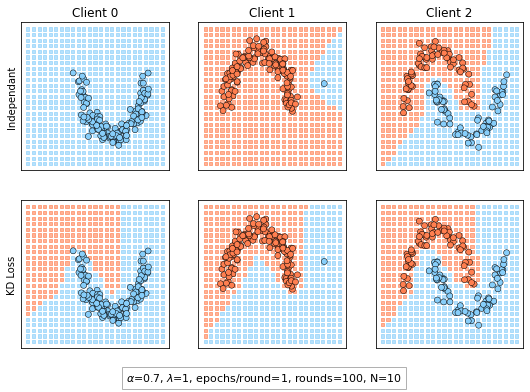

In [25]:
SIZE = 10


# Figure creation
xx, yy = np.meshgrid(np.arange(MIN, MAX, H), np.arange(MIN, MAX, H))
mesh_data = torch.cat((torch.from_numpy(xx.ravel()).unsqueeze(1), 
                       torch.from_numpy(yy.ravel()).unsqueeze(1)), dim=1).float()

fig, axs = plt.subplots(2, N_CLIENTS, figsize=(3*N_CLIENTS, 6), sharex=True, sharey=True)


# Independant training
axs[0,0].set_ylabel("Independant")
mesh_confidence = [None for _ in range(N_CLIENTS)]
mesh_class = [None for _ in range(N_CLIENTS)]
for i in range(N_CLIENTS):
    # Create decision map
    with torch.no_grad():
        model = client_models[i]
        model.eval()
        mesh_confidence[i], mesh_class[i]  = F.softmax(model(mesh_data), dim=1).max(dim=1)

    # Plot
    ax = axs[0,i]
    #ax.contourf(xx, yy, mesh_outputs[i].reshape(xx.shape), cmap=CMAP_AREA, alpha=0.6)
    ax.scatter(xx, yy, s=S,
               c=[COLORS[j] for j in mesh_class[i]], alpha=ALPHA_AREA, marker=MARKER_AREA)
    
    #data = val_ds_list[i]
    data = train_ds_list[i]
    ax.scatter(data.features[:,0], 
               data.features[:,1], 
               c=[COLORS[i] for i in data.targets], marker=MARKER, edgecolors=EC, lw=LW)


    ax.set_title("Client {}".format(i))
    ax.tick_params(axis='both', which='both', bottom=False, 
                   left=False, labelbottom=False, labelleft=False)

# With KD
axs[1,0].set_ylabel("KD Loss")
mesh_confidence_KD = [None for _ in range(N_CLIENTS)]
mesh_class_KD = [None for _ in range(N_CLIENTS)]
for i in range(N_CLIENTS):
    # Create decision map
    with torch.no_grad():
        model = client_models_KD[i]
        model.eval()
        mesh_confidence_KD[i], mesh_class_KD[i]  = F.softmax(model(mesh_data), dim=1).max(dim=1)
    
    # Plot
    ax = axs[1,i]
    #ax.contourf(xx, yy, mesh_outputs_KD[i].reshape(xx.shape), cmap=CMAP_AREA, alpha=0.6)
    ax.scatter(xx, yy, s=S,
               c=[COLORS[j] for j in mesh_class_KD[i]], alpha=ALPHA_AREA, marker=MARKER_AREA)
    
    #data = val_ds_list[i]
    data = train_ds_list[i]
    ax.scatter(data.features[:,0], 
               data.features[:,1],
               c=[COLORS[i] for i in data.targets], marker=MARKER, edgecolors=EC, lw=LW)


    #ax.set_title("Classifier Client {}".format(i))
    ax.tick_params(axis='both', which='both', bottom=False, 
                   left=False, labelbottom=False, labelleft=False)

fig.text(0.5, 0.05, 
         r"$\alpha$={}, $\lambda$={}, epochs/round={}, rounds={}, N={}".format(ALPHA, LAMBDA, EPOCHS_PER_ROUND, ROUNDS, RANDOM_SAMPLES), 
         ha="center", fontsize=11, bbox={"facecolor":"white", "alpha":0.3, "pad":4})

fig.savefig("./figures/2D/lambda/moons2D_N3.png", bbox_inches="tight", dpi=200)